In [1]:
import locale
#locale.getpreferredencoding = lambda: "UTF-8"
!pip install torch
!pip install numpy
!pip install numba
!pip3 install Cython
from numba import cuda
#device = cuda.get_current_device() 
#device.reset()


[notice] A new release of pip available: 23.0 -> 23.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 23.0 -> 23.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 23.0 -> 23.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 23.0 -> 23.1.1
[notice] To update, run: pip install --upgrade pip


In [41]:
import torch
import torch.nn as nn
from torch.autograd import Function
from torch.cuda.amp import custom_bwd, custom_fwd
import torch.nn.functional as F
import numpy as np
from torch.nn.parameter import Parameter
print(torch.__version__)

1.12.1+cu113


In [ ]:
from google.colab import files
uploaded = files.upload()

In [42]:
gt_densities = torch.load("../saved-densities/densities.pt",map_location=torch.device('cuda'))
print(gt_densities.shape)
print(f"gt_densities.min(): {gt_densities.min().item():>7f}")
print(f"gt_densities.max(): {gt_densities.max().item():>7f}")
print(f"gt_densities.mean(): {gt_densities.mean().item():>7f}")
print(f"gt_densities.std(): {gt_densities.std().item():>7f}")
nonzerogt = gt_densities
(gt_densities>2000).sum()
#print(nonzerogt)
#nonzerogt = nonzerogt[nonzerogt>0.1]
#stat = torch.quantile(nonzerogt.flatten(),0.999)
#print(stat)
#plt.hist(nonzerogt.flatten().cpu().detach().numpy())

torch.Size([380, 380, 380])
gt_densities.min(): 0.000000
gt_densities.max(): 2000.000000
gt_densities.mean(): 5.839085
gt_densities.std(): 76.802063


tensor(0, device='cuda:0')

In [43]:
class _TruncExp(Function):  # pylint: disable=abstract-method
    # Implementation from torch-ngp:
    # https://github.com/ashawkey/torch-ngp/blob/93b08a0d4ec1cc6e69d85df7f0acdfb99603b628/activation.py
    @staticmethod
    @custom_fwd(cast_inputs=torch.float32)
    def forward(ctx, x):  # pylint: disable=arguments-differ
        ctx.save_for_backward(x)
        return torch.exp(x)

    @staticmethod
    @custom_bwd
    def backward(ctx, g):  # pylint: disable=arguments-differ
        x = ctx.saved_tensors[0]
        return g * torch.exp(x.clamp(-15, 15))


trunc_exp = _TruncExp.apply

In [48]:
def make_gaussian_kernel(sigma):
      ks = int(sigma * 5)
      if ks % 2 == 0:
          ks += 1
      ts = torch.linspace(-ks // 2, ks // 2 + 1, ks)
      gauss = torch.exp((-(ts / sigma)**2 / 2))
      kernel = gauss / gauss.sum()

      return kernel

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(1, 16),
            nn.ReLU(),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
            )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


class TCNNGaussianNeRFField(nn.Module):
    """TCNN implementation of the gaussian NeRF Field.

    Args:
        aabb: parameters of scene aabb bounds
        num_layers: number of hidden layers
        hidden_dim: dimension of hidden layers
        geo_feat_dim: output geo feat dimensions
        num_layers_color: number of hidden layers for color network
        hidden_dim_color: dimension of hidden layers for color network
        use_appearance_embedding: whether to use appearance embedding
        num_images: number of images, required if use_appearance_embedding is True
        appearance_embedding_dim: dimension of appearance embedding
        contraction_type: type of contraction
        num_levels: number of levels of the hashmap for the base mlp
        log2_hashmap_size: size of the hashmap for the base mlp
    """
    
    def __init__(
        self,
        aabb = torch.tensor(1.5),
        sigma = 0.4,
        f_init = "rand",
        f_transition_function = "sigmoid",
        f_grid_resolution = 380,
        g_transition_function = "sigmoid",
        g_transition_alpha = 4.0,
        g_transition_alpha_increments = 0.0,
        occupancy_to_density_transformation_function = "inverted_external_log",
        density_multiplier = 100000.0,
        num_layers: int = 2,
        hidden_dim: int = 64,
        geo_feat_dim: int = 15,
        num_layers_color: int = 3,
        hidden_dim_color: int = 64,
        use_appearance_embedding: bool = False,
        appearance_embedding_dim: int = 32,
        num_levels: int = 16,
        log2_hashmap_size: int = 19,
    ) -> None:
        super().__init__()

        self.aabb = Parameter(aabb, requires_grad=False)
        self.geo_feat_dim = geo_feat_dim

        #learnable f^
        if f_init == "ones":
          if torch.cuda.is_available():
            self.f = Parameter(torch.ones(f_grid_resolution,f_grid_resolution,f_grid_resolution,device="cuda"))
          else:
            self.f = Parameter(torch.ones(f_grid_resolution,f_grid_resolution,f_grid_resolution))
        elif f_init == "zeros":
          if torch.cuda.is_available():
            self.f = Parameter(torch.zeros(f_grid_resolution,f_grid_resolution,f_grid_resolution,device="cuda"))
          else:
            self.f = Parameter(torch.zeros(f_grid_resolution,f_grid_resolution,f_grid_resolution))
        elif f_init == "spread":
          if torch.cuda.is_available():
            self.f = Parameter(6*torch.rand(f_grid_resolution,f_grid_resolution,f_grid_resolution,device="cuda")-3)
          else:
            self.f = Parameter(6*torch.rand(f_grid_resolution,f_grid_resolution,f_grid_resolution)-3)
        else :
          if torch.cuda.is_available():
            self.f = Parameter((1/2)*(torch.rand(f_grid_resolution,f_grid_resolution,f_grid_resolution, device = "cuda"))+(1/2)) #random uniformly distributed between 1/2 and 1
          else:
            self.f = Parameter((1/2)*(torch.rand(f_grid_resolution,f_grid_resolution,f_grid_resolution))+(1/2)) #random uniformly distributed between 1/2 and 1
          
        

        #this function will be applied everytime f^ is queried
        self.f_transition_function = f_transition_function

        #this function will be applied after occuapncy is calculated to get density
        self.occupancy_to_density_transformation_function = occupancy_to_density_transformation_function
        
        #store sigma for certification radii calculation
        self.sigma = sigma

        #in order to apply this kernel, it needs to be in the same device as f
        self.gaussian_kernel = make_gaussian_kernel(sigma).cuda()

        #this function will be applied to the smoothed grid in order to get occupancy
        self.g_transition_function = g_transition_function

        #starting alpha value to be used in case g_transition_function is sigmoid
        self.g_transition_alpha = g_transition_alpha

        #increments to be applied every step
        self.g_transition_alpha_increments = g_transition_alpha_increments

        #constant multiplier of output density
        self.density_multiplier = Parameter(torch.tensor(density_multiplier))

        if self.occupancy_to_density_transformation_function == "mlp":
          self.transfer_network = NeuralNetwork().cuda()

    def apply_3d_gaussian_blur(self,input_grid):
        # Make a test volume
        vol = input_grid

        # use class kernel
        k = self.gaussian_kernel

        # Separable 1D convolution
        vol_in = vol[None, None, ...]
        k1d = k[None, None, :, None, None]
        for i in range(3):
            vol_in = vol_in.permute(0, 1, 4, 2, 3)
            vol_in = F.conv3d(vol_in, k1d, stride=1, padding=(len(k) // 2, 0, 0))
        vol_3d_sep = vol_in
        #print((vol_3d- vol_3d_sep).abs().max()) # something ~1e-7
        #print(torch.allclose(vol_3d, vol_3d_sep)) # allclose checks if it is around 1e-8
        return vol_3d_sep
        
    def forward(self):
        if self.f_transition_function == "relu":
            smoothed_grid = self.apply_3d_gaussian_blur(torch.nn.ReLU()(self.f))
        elif self.f_transition_function == "sigmoid":
            smoothed_grid = self.apply_3d_gaussian_blur(torch.nn.Sigmoid()(self.f))
        else:
            smoothed_grid = self.f

        if self.g_transition_function == "sigmoid":
            density_before_activation = torch.nn.Sigmoid()(self.g_transition_alpha*(smoothed_grid-(1/2)))
        else:
            density_before_activation = smoothed_grid
            
        #density_before_activation = arg_maxed_smoothed_grid
        #density_before_activation = density_before_activation.view(-1,1) #to match previous instant-ngp implementation
        density_before_activation = density_before_activation #to match previous instant-ngp implementation


        # Rectifying the density with an exponential is much more stable than a ReLU or
        # softplus, because it enables high post-activation (float32) density outputs
        # from smaller internal (float16) parameters.
        if self.occupancy_to_density_transformation_function == "linear":
            density = self.density_multiplier * density_before_activation
        elif self.occupancy_to_density_transformation_function == "internal_exponential":
            density = trunc_exp(self.density_multiplier * density_before_activation)
        elif self.occupancy_to_density_transformation_function == "external_exponential":
            density = self.density_multiplier * trunc_exp(density_before_activation)
        elif self.occupancy_to_density_transformation_function == "inverted_external_log":
            self.density_multiplier = nn.Parameter(torch.clamp(self.density_multiplier, min=10))
            density = -self.density_multiplier * torch.log(1.0000001 - density_before_activation)
        elif self.occupancy_to_density_transformation_function == "mlp":
            density = self.transfer_network(density_before_activation)
        elif self.occupancy_to_density_transformation_function == "please_work":
            density = density_before_activation
        else:
            density = self.density_multiplier * trunc_exp(density_before_activation)
        #print(f"density.min(): {density.min().item():>7f}")
        #print(f"density.max(): {density.max().item():>7f}")
        #print(f"density.mean(): {density.mean().item():>7f}")
        #print(f"density.std(): {density.std().item():>7f}")

        return density

Field_grid = TCNNGaussianNeRFField(occupancy_to_density_transformation_function = "inverted_external_log",f_init = "spread")

In [49]:
def train_iter(model, loss_fn, optimizer,scheduler):
        # Compute prediction and loss
        pred = model()
        loss = loss_fn(pred.view(-1,1), gt_densities.view(-1,1))
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        #import pdb;pdb.set_trace()
        optimizer.step()
        scheduler.step()

        return loss

        
def train_loop(model,learning_rate = 1e-2, epochs = 20000):
    
    loss_fn =  nn.MSELoss(reduction='sum')
    
    #optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
    optimizer = torch.optim.SGD([
                {'params': list(Field_grid.parameters())[1], 'lr': 1e-11},
                {'params': list(Field_grid.parameters())[2], 'lr': 1e-9}
                ])
    print(optimizer.param_groups[0]["lr"])
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3000, gamma=0.97)
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        loss = train_iter(model, loss_fn, optimizer,scheduler)
        if t % 1 == 0:
          loss = loss.item()
          current_lr = optimizer.param_groups[0]["lr"]
          print(f"loss: {loss:>7f}  [{t:>5d}/{epochs:>5d}]")
          print(f"lr: {current_lr}")
          #print(f"density_multiplier: {model.density_multiplier.item():>7f}")
          print(f"model.f.min(): {model.f.min().item():>7f}")
          print(f"model.f.max(): {model.f.max().item():>7f}")
          print(f"model.f.mean(): {model.f.mean().item():>7f}")
          print(f"model.f.std(): {model.f.std().item():>7f}")
          print(f"model.f gradients mean: {list(model.parameters())[1].grad.mean().item()}")
          print(f"model.f gradients std: {list(model.parameters())[1].grad.std().item()}")
    print("Done!")

In [50]:
torch.backends.cudnn.enabled = False
train_loop(model=Field_grid)

1e-11
Epoch 1
-------------------------------
loss: 645576465542283264.000000  [    0/20000]
lr: 1e-11
model.f.min(): -3.000771
model.f.max(): 2.939637
model.f.mean(): -0.063969
model.f.std(): 1.688511
model.f gradients mean: 6375333376.0
model.f gradients std: 5342057472.0
Epoch 2
-------------------------------
loss: 607704749596213248.000000  [    1/20000]
lr: 1e-11
model.f.min(): -3.001541
model.f.max(): 2.876366
model.f.mean(): -0.127199
model.f.std(): 1.644159
model.f gradients mean: 6323016192.0
model.f gradients std: 5342576128.0
Epoch 3
-------------------------------
loss: 570251157306343424.000000  [    2/20000]
lr: 1e-11
model.f.min(): -3.002311
model.f.max(): 2.809890
model.f.mean(): -0.189682
model.f.std(): 1.599134
model.f gradients mean: 6248317952.0
model.f gradients std: 5330608640.0
Epoch 4
-------------------------------
loss: 533435797156659200.000000  [    3/20000]
lr: 1e-11
model.f.min(): -3.003080
model.f.max(): 2.739937
model.f.mean(): -0.251204
model.f.std(): 

In [39]:
prediction = torch.squeeze(Field_grid())
print(prediction.shape)

torch.Size([380, 380, 380])


tensor(2.8026e-45, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2000., device='cuda:0', grad_fn=<MaxBackward1>)
tensor(5.8391, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(275256, device='cuda:0')


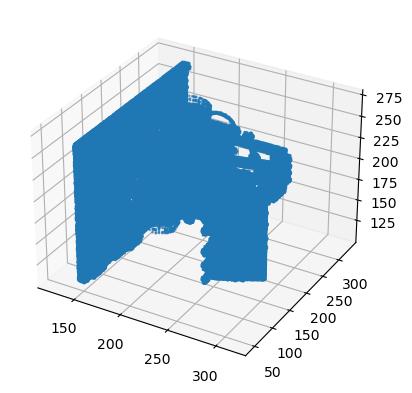

In [15]:
import matplotlib.pyplot as plt
ax = plt.figure().add_subplot(projection="3d")
print(gt_densities.min())
print(gt_densities.max())
print(gt_densities.mean())
occupancy = gt_densities>300
aux = torch.nonzero(occupancy, as_tuple=True)
print(occupancy.sum())
aux[0].shape
ax.scatter(aux[0].cpu().numpy(),aux[1].cpu().numpy(),aux[2].cpu().numpy(),s=1)

In [40]:
import matplotlib.pyplot as plt
ax = plt.figure().add_subplot(projection="3d")
print(prediction.min())
print(prediction.max())
print(prediction.mean())
occupancy = prediction>300
aux = torch.nonzero(occupancy, as_tuple=True)
print(occupancy.sum())
aux[0].shape
ax.scatter(aux[0].cpu().numpy(),aux[1].cpu().numpy(),aux[2].cpu().numpy(),s=1)

tensor(12692.7871, device='cuda:0', grad_fn=<MinBackward1>)
tensor(12692.7871, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(12692.7939, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(54872000, device='cuda:0')


Error in callback <function _draw_all_if_interactive at 0x7f7c300433a0> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f7c2ffff5e0> (for post_execute):


KeyboardInterrupt: 

In [18]:
!pip install trimesh

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 680.8/680.8 kB 26.7 MB/s eta 0:00:00

[notice] A new release of pip available: 23.0 -> 23.1.1
[notice] To update, run: pip install --upgrade pip


In [21]:
import trimesh
bcd = trimesh.base.Trimesh(vertices = torch.cat([x.unsqueeze(0) for x in aux], dim=0).cpu().numpy().T)
print(bcd.vertices.shape)
_ = bcd.export("predicted.ply")

(928295, 3)


In [ ]:
torch.cat([aux[0],aux[1],aux[2]])

In [ ]:
torch.cat([x.unsqueeze(0) for x in aux], dim=0).shape